# Exercise - VaR


## Data

This problem uses `weekly` return data from `data/spx_returns_weekly.xlsx`.

Choose any `4` stocks to evaluate below.

For example,

- `AAPL`
- `META`
- `NVDA`
- `TSLA`


In [2]:
# imports and settings
import numpy as np
import pandas as pd
from pandas import ExcelFile

import matplotlib.pyplot as plt
import seaborn as sns

from tabulate import tabulate
from IPython.display import Markdown as md

# matplotlib settings
%matplotlib inline
plt.rcParams['figure.figsize'] = (12,6)
plt.rcParams['font.size'] = 15
plt.rcParams['legend.fontsize'] = 13

# pandas display settings
pd.options.display.float_format = "{:,.4f}".format

# autoreload
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
# data import
data = ExcelFile("spx_returns_weekly.xlsx")
info = data.parse("s&p500 names", index_col=0)
benchmark_info = data.parse("benchmark names", index_col=0)
benchmark_returns = data.parse("benchmark rets", index_col=0)
spx_returns = data.parse("s&p500 rets", index_col=0)

display(info)
display(benchmark_info)

stocks = spx_returns[
    [
        "AAPL",
        "META",
        "NVDA",
        "TSLA",
    ]
]

,name,mkt cap
ticker,,
A,Agilent Technologies Inc,"33,161,716,346.7200"
AAPL,Apple Inc,"3,008,822,147,700.0000"
ABBV,AbbVie Inc,"334,132,796,587.3200"
ABNB,Airbnb Inc,"87,276,953,780.8500"
ABT,Abbott Laboratories,"232,094,184,431.0000"
...,...,...
XYL,Xylem Inc/NY,"31,058,889,533.9300"
YUM,Yum! Brands Inc,"39,787,838,673.1400"
ZBH,Zimmer Biomet Holdings Inc,"18,366,220,000.0200"


,security_name
ticker,
GLD US Equity,SPDR Gold Shares
IEF US Equity,iShares 7-10 Year Treasury Bon
IYR US Equity,iShares U.S. Real Estate ETF
SPY US Equity,SPDR S&P 500 ETF Trust
TLT US Equity,iShares 20+ Year Treasury Bond
USO US Equity,United States Oil Fund LP
XBTUSD BGN Curncy,Bitcoin/US DOLLAR


# 1 Diversification


## 1.1

Using the full sample, calculate for each series the (unconditional)

- volatility
- empirical VaR (.05)
- empirical CVaR (.05)

Recall that by **empirical** we refer to the direct quantile estimation. (For example, using `.quantile()` in pandas.


In [4]:
# 1.1 Code


def compute_metrics(returns, annualization=52):
    df = pd.DataFrame(
        {
            "Volatility": returns.std() * np.sqrt(annualization),
            "Mean Return": returns.mean() * annualization,
            "Sharpe Ratio": (returns.mean() * annualization)
            / (returns.std() * np.sqrt(annualization)),
            "VaR (5%)": returns.quantile(0.05),
            "CVaR (5%)": returns[returns <= returns.quantile(0.05)].mean(),
        },
        index=[returns.name] if isinstance(returns, pd.Series) else returns.columns,
    )
    return df.T


df = compute_metrics(stocks)
corr = stocks.corr()
sns.heatmap(corr.where(corr != 1, np.nan), annot=True, cmap="coolwarm")

display(df)

,AAPL,META,NVDA,TSLA
Volatility,0.2766,0.3513,0.4633,0.5864
Mean Return,0.2387,0.2619,0.6456,0.4698
Sharpe Ratio,0.8629,0.7455,1.3935,0.8010
VaR (5%),-0.0564,-0.0700,-0.0869,-0.1174
CVaR (5%),-0.0831,-0.1032,-0.1165,-0.1478


## 1.2

Form an equally-weighted portfolio of the investments.

Calculate the statistics of `1.1` for this portfolio, and compare the results to the individual return statistics. What do you find? What is driving this result?

- **This portfolio achieves the second lowest `vol`, `VaR`, and `CVaR` of the individual assets (AAPL has lower numbers on all 3 metrics). However, the portfolios `Sharpe` ratio beats `AAPL`'s Sharpe ratio (has the second highest Sharpe ratio among the individual assets). This is driven by the diversification effect. Interestingly, `NVDA` has a higher `Sharpe Ratio` than the equally weighted portfolio, likely driven by its recent extremely strong performance.**


In [5]:
# 1.2 Code: Equal weight portfolio and metrics
equal_weight_returns = stocks.mean(axis=1).rename("Portfolio")
compute_metrics(equal_weight_returns)

,Portfolio
Volatility,0.3155
Mean Return,0.4040
Sharpe Ratio,1.2803
VaR (5%),-0.0619
CVaR (5%),-0.0850


## 1.3

Re-calculate `1.2`, but this time drop your most volatile asset, and replace the portion it was getting with 0. (You could imagine we're replacing the most volatile asset with a negligibly small risk-free rate.)

In comparing the answer here to 1.2, how much risk is your most volatile asset adding to the portfolio? Is this in line with the amount of risk we measured in the stand-alone risk-assessment of `1.1`?

- **By dropping the most volatile asset (TSLA), the equally weighted portfolio's `vol`, `VaR`, and `CVaR` all decrease, while the mean return also significantly decreases. It appears the `TSLA` was contributing a significant amount of risk and return to the portfolio ($\approx 10\%$ additional volatilty and $\approx 12\%$ additional mean return). Clearly this adds much less risk than the stand-alone risk of `TSLA`. Interestingly, our portfolio's `Sharpe Ratio` actually increases slightly by dropping `TSLA`, indicating that `TSLA` was not a good diversifier within this portfolio.**


In [6]:
# 1.3 Code: Set most volatile asset to zero and recompute metrics
most_volatile_asset = compute_metrics(stocks).idxmax(axis=1)["Volatility"]
print(f"Setting most volatile asset to zero: {most_volatile_asset}")
stocks_dropped = stocks.copy()
stocks_dropped[most_volatile_asset] = 0
equal_weight_returns_dropped = stocks_dropped.mean(axis=1).rename(
    f"Portfolio-ex {most_volatile_asset}"
)
compute_metrics(equal_weight_returns_dropped)

Setting most volatile asset to zero: TSLA


,Portfolio-ex TSLA
Volatility,0.2184
Mean Return,0.2866
Sharpe Ratio,1.3123
VaR (5%),-0.0425
CVaR (5%),-0.0605


---


# 2. Dynamic Measures


## 2.1

Let's measure the **conditional** statistics of the equally-weighted portfolio of `1.2`, as of the end of the sample.

#### Volatility

For each security, calculate the **rolling** volatility series, $\sigma_t$, with a window of $m=26$.

The value at $\sigma_t$ in the notes denotes the estimate using data through time $t-1$, and thus (potentially) predicting the volatility at $\sigma_{t}$.


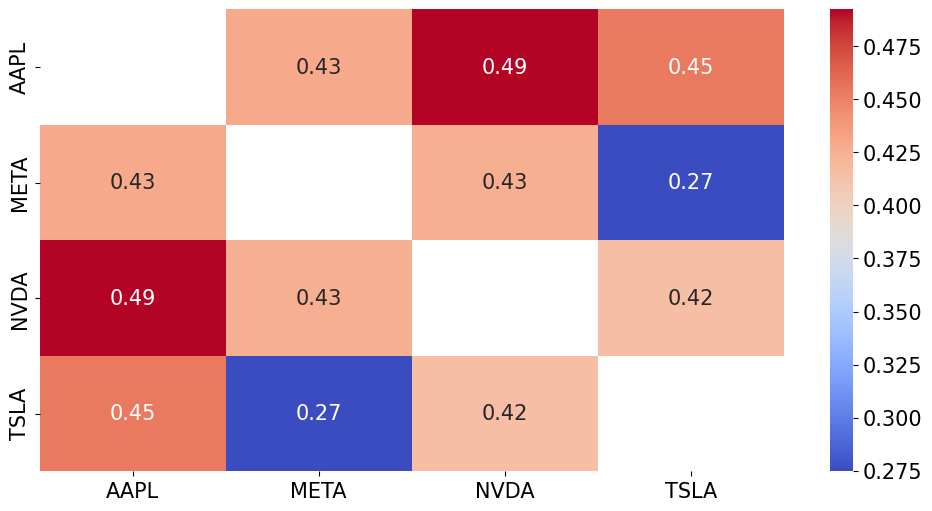

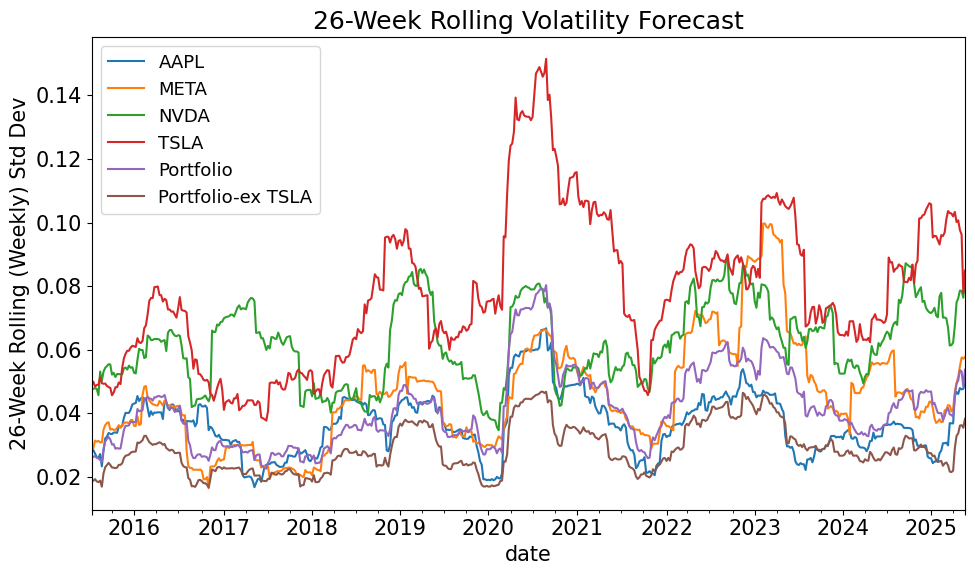

,AAPL,META,NVDA,TSLA,Portfolio,Portfolio-ex TSLA
date,,,,,,
2015-07-10,0.0281,0.0292,0.0473,0.0489,0.0257,0.0186
2015-07-17,0.0285,0.0291,0.0478,0.0500,0.0265,0.0189
2015-07-24,0.0273,0.0315,0.0479,0.0484,0.0265,0.0193
2015-07-31,0.0263,0.0311,0.0477,0.0490,0.0260,0.0186
2015-08-07,0.0260,0.0314,0.0457,0.0490,0.0259,0.0184
...,...,...,...,...,...,...
2025-04-25,0.0461,0.0515,0.0762,0.1007,0.0503,0.0337
2025-05-02,0.0479,0.0548,0.0786,0.0977,0.0536,0.0362
2025-05-09,0.0476,0.0576,0.0786,0.0962,0.0532,0.0363


In [7]:
# 2.1 Code: Rolling volatility forecast
returns = pd.concat(
    [stocks, equal_weight_returns, equal_weight_returns_dropped], axis=1
)
rolling_vol = returns.rolling(window=26).std().shift(1).dropna()
fig, ax = plt.subplots(figsize=(10, 6))
rolling_vol.plot(ax=ax)
ax.set_ylabel("26-Week Rolling (Weekly) Std Dev")
ax.set_title("26-Week Rolling Volatility Forecast")
plt.tight_layout()
plt.show()
rolling_vol

#### Mean

Suppose we can approximate that the daily mean return is zero.


In [32]:
# TODO: I have no idea what this is asking

In [8]:
# Calculate VaR
z = -1.65
VaR_last_date = pd.DataFrame([z * rolling_vol.iloc[-1]], index=["VaR (Weekly)"])
VaR_last_date

,AAPL,META,NVDA,TSLA,Portfolio,Portfolio-ex TSLA
VaR (Weekly),-0.0819,-0.0953,-0.1365,-0.1400,-0.0887,-0.0632


In [10]:
from scipy.stats import norm 
alpha=0.05
# Calculate CVaR
z = -1.65
CVaR_last_date = pd.DataFrame([-rolling_vol.iloc[-1] * norm.pdf(z)/alpha], index=["CVaR (Weekly)"])
CVaR_last_date

,AAPL,META,NVDA,TSLA,Portfolio,Portfolio-ex TSLA
CVaR (Weekly),-0.1015,-0.1181,-0.1692,-0.1736,-0.1099,-0.0784


Parametric rolling VaR/CVaR use only the last 26 weeks and assume normality, while historical VaR/CVaR use the full sample. As a result, the parametric estimates are generally larger in magnitude, reflecting higher tail risk in recent periods toward the end of the sample.

## 2.2: Backtest VaR (Hit Test)

In [15]:
# Rolling Volatility: VaR
total_sample_var_rolling = rolling_vol * z

# Expanding Volatility
sigma_t_expanding = returns.expanding(min_periods=2).std()
total_sample_var_expanding = sigma_t_expanding * z

In [32]:
# Hit Rate
hit_rate_rolling = (total_sample_var_rolling > returns.iloc[26:]).sum() / len(returns) * 100
hit_rate_expanding = (total_sample_var_expanding > returns).sum() / len(returns) * 100

hit_results = pd.DataFrame({
    "Expanding VaR Hit Rate (%)": hit_rate_rolling,
    "Rolling VaR Hit Rate (%)": hit_rate_expanding
}, index = returns.columns)

hit_results

,Expanding VaR Hit Rate (%),Rolling VaR Hit Rate (%)
AAPL,4.9815,4.2435
META,4.2435,4.7970
NVDA,4.2435,3.1365
TSLA,4.9815,6.4576
Portfolio,4.0590,4.9815
Portfolio-ex TSLA,3.6900,4.7970


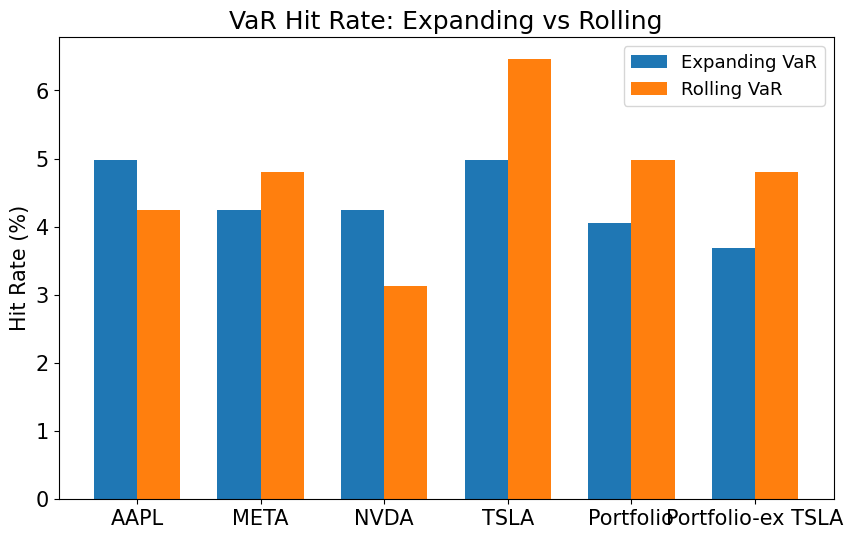

In [37]:
# Set up figure
plt.figure(figsize=(10,6))

# X-axis positions
x = np.arange(len(returns.columns))

# Bar width
width = 0.35

# Plot bars
plt.bar(x - width/2, hit_results['Expanding VaR Hit Rate (%)'], width, label='Expanding VaR')
plt.bar(x + width/2, hit_results['Rolling VaR Hit Rate (%)'], width, label='Rolling VaR')

# Labels and title
plt.xticks(x, returns.columns)
plt.ylabel('Hit Rate (%)')
plt.title('VaR Hit Rate: Expanding vs Rolling')
plt.legend()

plt.show()

---
